In [2]:
from sklearn import model_selection ,metrics
from sklearn.preprocessing import MinMaxScaler

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

from keras import backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Conv2D ,MaxPooling2D,Flatten ,Dense,Dropout

In [21]:
import skeras


In [56]:
class CNN(Model):
    def __init__(model ,nb_classes ,in_shape = None):
        model.nb_classes = nb_classes
        model.in_shape = in_shape
        model.build_model()
        super().__init__(model.x,model.y)
        model.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])
        
    def build_model(model):
        nb_classes = model.nb_classes
        in_shape = model.in_shape
        x = Input(in_shape)
        h = Conv2D(32, kernel_size=(3,3), activation='relu', input_shape =in_shape)(x)
        h = Conv2D(64,(3,3),activation='relu')(h)
        h = MaxPooling2D(pool_size=(2,2))(h)
        h = Dropout(0.25)(h)
        h = Flatten()(h)
        z_cl = h
        h = Dense(128,activation ='relu')(h)
        h = Dropout(0.5)(h)
        z_fl = h
        y = Dense(nb_classes, activation = 'softmax', name ='preds')(h)
        model.cl_part =Model(x,z_cl)
        model.fl_part =Model(x,z_fl)
        model.x , model.y = x ,y

In [57]:
class DataSet():
    def __init__(self,X,y,nb_classes, scaling =True, test_size =0.2 , random_state =0):
        self.X =X
        self.add_channels()
        X= self.X
        X_train ,X_test ,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2 ,random_state =random_state)
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        if scaling:
            scaler = MinMaxScaler()
            n = X_train.shape[0]
            X_train =scaler.fit_transform(X_train.reshape(n,-1)).reshape(X_train.shape)
            n = X_test.shape[0]
            X_test =scaler.transform(X_test.reshape(n,-1)).reshape(X_test.shape)
            self.scaler =scaler
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test =  np_utils.to_categorical(y_test, nb_classes)
        self.X_train ,self.X_test = X_train,X_test
        self.Y_train ,self.Y_test = Y_train,Y_test
        self.y_train, self.y_test = y_train, y_test
        
    def add_channels(self):
        X = self.X
        
        if len(X.shape) == 3:
            N,img_rows, img_cols = X.shape
            
            if K.image_dim_ordering() == 'th':
                X = X.reshape(X.shape[0],i,img_rows,img_cols)
                input_shape = (1,img_rows,img_cols)
            else:
                X = X.reshape(X.shape[0],img_rows, img_cols,1)
                input_shape = (img_rows, img_cols,1)
        else:
            input_shape = X.shape[1:]
        self.X = X
        self.input_shape = input_shape
        

In [67]:
class Machine():
    def __init__(self, X, y, nb_classes = 2, fig= True):
        self.nb_classes = nb_classes
        self.set_data(X,y)
        self.set_model()
        self.fig = fig
        
    def set_data(self,X,y):
        nb_classes = self.nb_classes
        self.data = DataSet(X,y,nb_classes)
    
    def set_model(self):
        nb_classes = self.nb_classes
        data = self.data
        self.model = CNN(nb_classes= nb_classes, in_shape = data.input_shape)
    
    def fit(self, nb_epoch =10 , batch_size = 128 , verbose =1):
        data = self.data
        model =self.model
        
        history = model.fit(data.X_train ,data.Y_train,batch_size =batch_size, epochs= nb_epoch,
                           verbose = verbose,
                           validation_data = (data.X_test,data.Y_test))
        return history
    
    def run(self,nb_epoch=10 , batch_size =128 ,verbose =1):
        data = self.data
        model = self.model
        fig = self.fig
        
        history = self.fit(nb_epoch=nb_epoch, batch_size=batch_size,verbose = verbose)
        score = model.evaluate(data.X_test , data.Y_test, verbose =0)
        
        print('Confusion matrix')
        Y_test_pred = model.predict(data.X_test,verbose =0)
        y_test_pred = np.argmax(Y_test_pred,axis=1)
        print(metrics.confusion_matrix(data.y_test,y_test_pred))
        
        print('Score :', score[0])
        print('Acc : ',score[1])
        
        if fig :
            plt.figure(figsize=(12,4))
            plt.subplot(1,2,1)
            skeras.plot_acc(history)
            plt.subplot(1,2,2)
            skeras.plot_loss(history)
            plt.show()
        
        self.history = history

In [68]:
from keras import datasets
import keras
assert keras.backend.image_data_format() == 'channels_last'

In [69]:
class newMachine(Machine):
    def __init__(self):
        (X,y),(x_test,y_test) = datasets.cifar10.load_data()
        super().__init__(X,y,nb_classes =10)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 16s 407us/step - loss: 1.8610 - acc: 0.3278 - val_loss: 1.5250 - val_acc: 0.4520
Epoch 2/10
40000/40000 [==============================] - 11s 267us/step - loss: 1.4334 - acc: 0.4885 - val_loss: 1.2393 - val_acc: 0.5491
Epoch 3/10
40000/40000 [==============================] - 11s 266us/step - loss: 1.2521 - acc: 0.5561 - val_loss: 1.1114 - val_acc: 0.6026
Epoch 4/10
40000/40000 [==============================] - 11s 267us/step - loss: 1.1317 - acc: 0.6011 - val_loss: 1.0224 - val_acc: 0.6388
Epoch 5/10
40000/40000 [==============================] - 11s 268us/step - loss: 1.0426 - acc: 0.6351 - val_loss: 1.0149 - val_acc: 0.6398
Epoch 6/10
40000/40000 [==============================] - 11s 269us/step - loss: 0.9704 - acc: 0.6574 - val_loss: 0.9562 - val_acc: 0.6645
Epoch 7/10
40000/40000 [==============================] - 11s 269us/step - loss: 0.9103 - acc: 0.6811 - val_loss: 0.

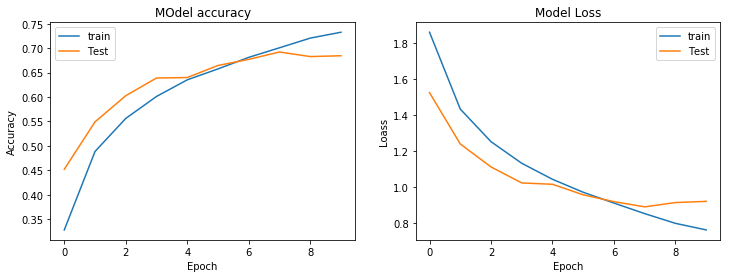

In [70]:
m = newMachine()
m.run()